
# Credit card Fraud Detection using imbalanced Dataset

In [1]:
import pandas as pd #accesing data and manup
import numpy as np
import time

import seaborn as sns #visualization
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler #standardizing
from sklearn.model_selection import train_test_split,RandomizedSearchCV

from IPython.display import Image #adding images in jup
from IPython.core.display import HTML 

from sklearn.manifold import TSNE # DIM reduction
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE # Over sampling
#pip install imblearn

from sklearn.linear_model import LogisticRegression #Classifier

from sklearn.pipeline import make_pipeline # pipline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.metrics import classification_report_imbalanced # evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

from sklearn.model_selection import KFold, StratifiedKFold # for CV

In [3]:
data=pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# numerical representation of the distribution
print(data[['Amount','Class']].describe())

              Amount          Class
count  284807.000000  284807.000000
mean       88.349619       0.001727
std       250.120109       0.041527
min         0.000000       0.000000
25%         5.600000       0.000000
50%        22.000000       0.000000
75%        77.165000       0.000000
max     25691.160000       1.000000


In [5]:
# Good No Null Values!
data.isnull().sum().max()

0

In [6]:
# columns names has been masked because of C-C privacy concern !!
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
# The classes are heavily skewed.
print('No Frauds :-', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds :-', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds :- 99.83 % of the dataset
Frauds :- 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n [ 0: No Fraud -- 1: Fraud ]')

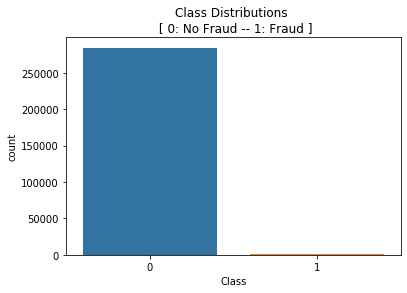

In [8]:
# visual representaion of the imbalanced class.
sns.countplot('Class', data=data)
plt.title('Class Distributions \n [ 0: No Fraud -- 1: Fraud ]')

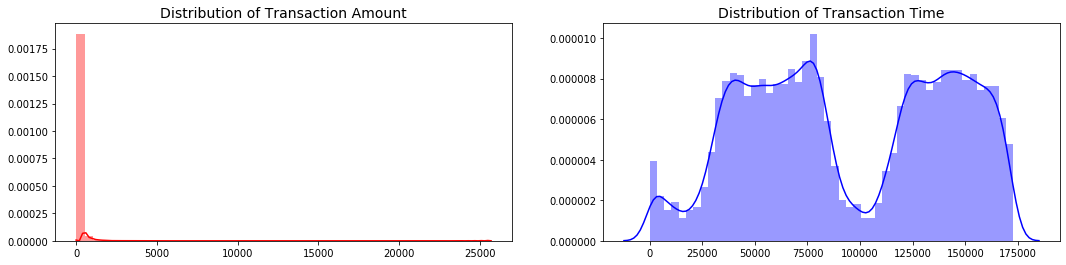

In [9]:
#ax = sns.distplot(data['Amount'],color='r').set_title('Distribution of Transaction Amount')
#ax = sns.distplot(data['Time'],color='r').set_title('Distribution of Transaction Time')

ig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='red')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)

sns.distplot(time_val, ax=ax[1], color='blue')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

plt.show()

In [10]:
# Scaling Time and Amount
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

# Creating Sub-Samples

    Subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions
    
    WHY ?
    
    Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    
    Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.


In [11]:
# spliting the data before under-sampling !!
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

X = data.drop('Class', axis=1)
y = data['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [12]:
# giving countof unique values, to make sure that the 
# train and test label distribution are similarly distributed

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain)) # in terms of percentage %
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


### Random Under Sampling
    "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

In [13]:
data = data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_data = data.loc[data['Class'] == 1]
non_fraud_data = data.loc[data['Class'] == 0][:492]

normal_distributed_data = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_data = normal_distributed_data.sample(frac=1, random_state=42)

new_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
195247,1.930962,-1.278703,-2.637005,-1.595651,1.528942,3.444457,-1.398023,0.915770,-0.107039,0.052069,...,0.609292,0.054801,0.609211,-0.148932,-0.077878,0.029457,-0.000338,0,1.355411,0.543639
8615,-3.891192,7.098916,-11.426467,8.607557,-2.065706,-2.985288,-8.138589,2.973928,-6.272790,-13.193415,...,-0.189709,-0.508629,-1.189308,1.188536,0.605242,1.881529,0.875260,1,-0.293440,-0.858363
160849,1.710832,-1.268853,-0.434118,-1.492192,-0.726370,0.592228,-0.962190,0.337896,2.409650,-1.170461,...,0.718611,0.259952,-1.004126,-0.625527,-0.257346,0.088600,-0.027459,0,1.137707,0.340782
249239,-0.082983,-3.935919,-2.616709,0.163310,-1.400952,-0.809419,1.501580,-0.471000,1.519743,-1.134454,...,-0.182305,-0.921017,0.111635,-0.071622,-1.125881,-0.170947,0.126221,1,15.021170,0.817878
102782,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,0.543187,...,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,1,-0.033676,-0.191908


(984, 31)


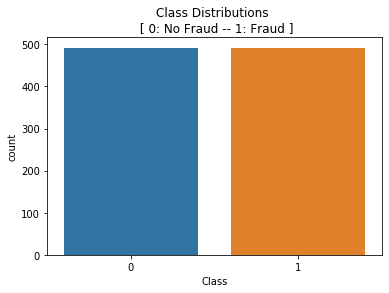

In [14]:
# visual representaion of the balanced class.
sns.countplot('Class', data=new_data)
plt.title('Class Distributions \n [ 0: No Fraud -- 1: Fraud ]')
print(new_data.shape)

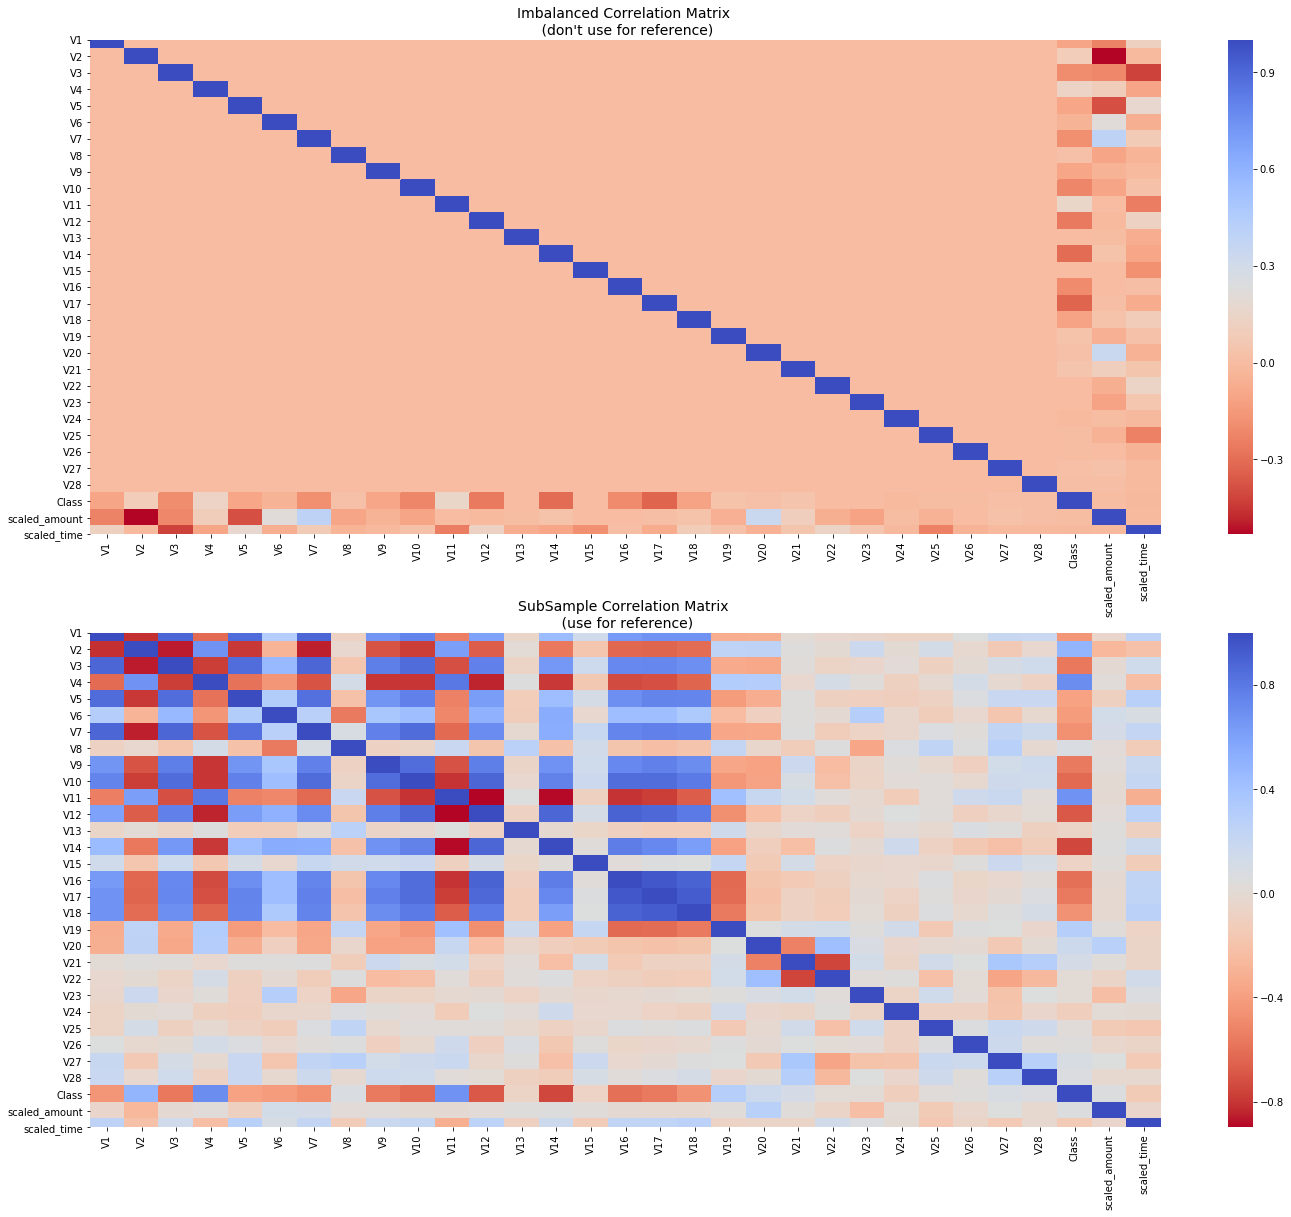

In [15]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_data.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

plt.show()

### SMOTE Technique (Over-Sampling)
    Synthetic Minority Over-sampling Technique. 
    Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. 
    This is another alternative for solving the "class imbalance problems"

In [16]:
Image(url= "https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png")

In [16]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) # SK-fold for splitting

log_reg_params = {'penalty': ['l2'], 'solver': ['sag','saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # range for Hyperparameters

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4) # initializing model

# SMOTE happens during Cross Validation not before..
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) 
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962


/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_ite

/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_ite

/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_ite

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9754350545326866
precision: 0.06039591323583075
recall: 0.9035702693930542
f1: 0.1131772700880391
---------------------------------------------------------------------------------------------------------------------------------------


/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [17]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     56864
       Fraud       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [46]:
# Simpler and Most commonly used Approach :-

In [41]:
# Apply PCA or T-sne for dimensionalty reduction :-

X = data.drop('Class', axis=1)
y = data['Class']


# # T-SNE Implementation
# t0 = time.time()
# X_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=20, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))


PCA took 5.6 s


In [18]:
X_reduced_pca.shape

(284807, 10)

In [48]:
# Traning Classifer with weights assigned to each class {0:1,1:9} :-
from lightgbm import LGBMClassifier
lgbm=LGBMClassifier(boosting_type='gbdt',max_depth=5,n_estimators=200,learning_rate=0.07,class_weight={0:1,1:9})

In [49]:
lgbm.fit(original_Xtrain, original_ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 9},
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.07, max_depth=5, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [50]:
# Evaluation :-
y_pred1_lgbm=lgbm.predict(original_Xtest)
print("Confusion Matrix: ",confusion_matrix(original_ytest, y_pred1_lgbm)) 
print("Accuracy using random forest: ",accuracy_score(original_ytest,y_pred1_lgbm)*100)
print("Recall Score using random forest: ", recall_score(original_ytest, y_pred1_lgbm)) 
print("classification report")
print(classification_report(original_ytest, y_pred1_lgbm)) 

Confusion Matrix:  [[56859     5]
 [   18    80]]
Accuracy using random forest:  99.95962220427653
Recall Score using random forest:  0.8163265306122449
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [51]:
def proba_(pred_pro1,x_test1,y_test1):  
    y_t_lgbm=[None]*pred_pro1.shape[0]
    for i in range(0,pred_pro1.shape[0]):
        if(pred_pro1[i][1]>=0.9):
                y_t_lgbm[i]=1
        else:
               y_t_lgbm[i]=0
    return y_t_lgbm

In [52]:
# It gives, the probability of occurance of 0 and 1 in a list
l=lgbm.predict_proba(original_Xtest)
print(l)

[[6.40616308e-04 9.99359384e-01]
 [9.99994452e-01 5.54820731e-06]
 [9.99844800e-01 1.55200454e-04]
 ...
 [9.99904663e-01 9.53373223e-05]
 [9.99943057e-01 5.69430228e-05]
 [9.99744072e-01 2.55928263e-04]]


In [53]:
for i in l:
    print(i.sum())
    break

1.0


In [54]:
thresh_proba=proba_(l,original_Xtest,original_ytest)

In [55]:
print("Confusion Matrix: ",confusion_matrix(original_ytest, thresh_proba)) 
print ("Accuracy:",accuracy_score(original_ytest,thresh_proba)*100) 
print("Recall Score: ", recall_score(original_ytest, thresh_proba)) 
print("classification report")
print(classification_report(original_ytest, thresh_proba)) 

Confusion Matrix:  [[56863     1]
 [   23    75]]
Accuracy: 99.95786664794073
Recall Score:  0.7653061224489796
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [56]:
# Learning curve

In [57]:
# LEARNING CURVES 
def plot_learning_curve(estimator, title, X, y, ylim=(0.5,1.1), cv=5, scoring='r2',obj_line=None,n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\adarsingh\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

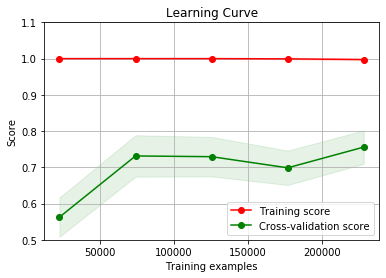

In [58]:
plot_learning_curve(lgbm,'Learning Curve',X,y)

In [85]:
# using on reduced dim X and Y

In [64]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced_pca, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.07,0.1, 0.3],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'class_weight':[{0:1,1:9}],
    'n_estimators':[190,200,400,700],
    'max_depth':[7,5,3]
    }

lgb_estimator = LGBMClassifier()

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
lgb_model = gsearch.fit(Xtrain, ytrain)

print(lgb_model.best_params_, lgb_model.best_score_)

In [70]:
lgbm=LGBMClassifier(boosting_type='gbdt',max_depth=3,n_estimators=200,learning_rate=0.10,class_weight={0:1,1:9})
lgbm.fit(Xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 9},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=3, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [62]:
# Evaluation :-
y_pred1_lgbm=lgbm.predict(Xtest)
print("Confusion Matrix: ",confusion_matrix(ytest, y_pred1_lgbm)) 
print("Accuracy using random forest: ",accuracy_score(ytest,y_pred1_lgbm)*100)
print("Recall Score using random forest: ", recall_score(ytest, y_pred1_lgbm)) 
print("classification report")
print(classification_report(ytest, y_pred1_lgbm)) 

Confusion Matrix:  [[56841    22]
 [   19    80]]
Accuracy using random forest:  99.92802219023208
Recall Score using random forest:  0.8080808080808081
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.78      0.81      0.80        99

    accuracy                           1.00     56962
   macro avg       0.89      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



<module 'matplotlib.pyplot' from 'C:\\Users\\adarsingh\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

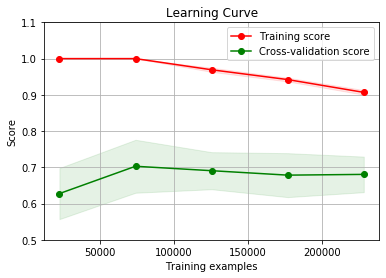

In [63]:
plot_learning_curve(lgbm,'Learning Curve',X,y)